# Autoencoder for feature highlighting ?

- http://cs.stanford.edu/people/karpathy/convnetjs/demo/autoencoder.html
- https://www.tensorflow.org/get_started/mnist/pros
- https://gertjanvandenburg.com/blog/autoencoder/

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [7]:
DATA_PATH = '/home/reflex/refleX/metadata/'
IMAGE_PATH = f'{DATA_PATH}labeled/original512/'
MODEL_HOME = '/home/reflex/refleX/results/autoencoder/'
TF_DATASET_PATH = f'{MODEL_HOME}dataset'

In [8]:
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
NUM_BATCHES = 16
NUM_TESTING_EXAMPLES = 32
NUM_ITERATIONS = 10000
IMAGE_SIZE = 512
USE_RELU = False
USE_CACHED = False

## Tensorboard helper functions

In [9]:
# TODO

## Define network architecture

- FC1, 50 neurons, tanh
- FC2, 50 neurons, tanh
- FC3, 2 neurons
- FC4, 50 neurons, tanh
- FC5 50 neurons, tanh
- readout layer

TODO: convolutions instead of fc layers

In [10]:
def fc_layer(previous, input_size, output_size, name_prefix=''):
    W = tf.get_variable(name=name_prefix+'_W', initializer=tf.truncated_normal(shape=[input_size, output_size], stddev=0.1))
    b = tf.get_variable(name=name_prefix+'_b', initializer=tf.truncated_normal(shape=[output_size]))
    return tf.matmul(previous, W) + b

In [11]:
def autoencoder(x):
    
    l1 = tf.nn.tanh(fc_layer(x, IMAGE_SIZE*IMAGE_SIZE, 10, 'l1'))
    l2 = tf.nn.tanh(fc_layer(l1, 10, 10, 'l2'))
    l3 = fc_layer(l2, 10, 10, 'l3')
    l4 = tf.nn.tanh(fc_layer(l3, 10, 10, 'l4'))
    #l5 = tf.nn.tanh(fc_layer(l4, 10, 10, 'l5'))
    if USE_RELU:
        out = tf.nn.relu(fc_layer(l4, 10, IMAGE_SIZE*IMAGE_SIZE, 'out'))
    else:
        out = fc_layer(l4, 10, IMAGE_SIZE*IMAGE_SIZE, 'out')

    loss = tf.losses.mean_squared_error(x, out)
    return loss, out, l3

## Run model

### Load data

In [12]:
if USE_CACHED:
    with np.load("/var/data/training_data.npy") as data:
        features = data["features"]
        labels = data["labels"]

else:
    images = np.ndarray(shape=(NUM_BATCHES*BATCH_SIZE, IMAGE_SIZE*IMAGE_SIZE), dtype=np.float32)
    for i, imname in enumerate(os.listdir(IMAGE_PATH)[:NUM_BATCHES*BATCH_SIZE]):
        images[i] = plt.imread(f'{IMAGE_PATH}{imname}').astype(np.float32).flatten()
    features = np.reshape(images, (NUM_BATCHES, BATCH_SIZE, IMAGE_SIZE*IMAGE_SIZE))
    labels = None # TODO
    # TODO save as with training_data.npy
    
    test_images = np.ndarray(shape=(NUM_TESTING_EXAMPLES, IMAGE_SIZE*IMAGE_SIZE), dtype=np.float32)
    for i, imname in enumerate(os.listdir(IMAGE_PATH)[NUM_BATCHES*BATCH_SIZE:NUM_BATCHES*BATCH_SIZE+NUM_TESTING_EXAMPLES]):
        test_images[i] = plt.imread(f'{IMAGE_PATH}{imname}').astype(np.float32).flatten()

#assert features.shape[0] == labels.shape[0] # TODO uncomment
#assert features.shape[-1] == features.shape[-2] # for square images only

test_images = features # FIXME remove

print(features.shape)
print(test_images.shape)

(16, 1, 262144)
(16, 1, 262144)


### Training

In [ ]:
tf.reset_default_graph()

x = tf.placeholder(features.dtype, features.shape[-2:])
iterator = tf.data.Dataset.from_tensor_slices((x)).make_initializable_iterator()
loss, output, latent = autoencoder(x)

saver = tf.train.Saver()

with tf.Session() as sess:
    
    train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer, feed_dict={x: features[0]})
    
    for iter_num in range(NUM_ITERATIONS):
        losses = []
        oo = None
        for batch_i in range(NUM_BATCHES):
            current_loss, _, oo, _lat = sess.run([loss, train_op, output, latent], feed_dict={ x: features[batch_i] })
            losses.append(current_loss)
            if iter_num%1000 == 0:
                print(_lat)
                _, ax = plt.subplots(1,2)
                ax[0].imshow(features[batch_i].reshape(IMAGE_SIZE, IMAGE_SIZE))
                ax[1].imshow(oo.reshape(IMAGE_SIZE, IMAGE_SIZE))
                plt.show()
        if iter_num%1000 == 0:
            print(f'Iteration {iter_num}: loss={np.mean(losses)}')

    print(f'Saved model in {saver.save(sess, "./TEMP")}')

### Restore session & test

INFO:tensorflow:Restoring parameters from ./TEMP
Model restored.
[[ 4.4693494 -1.4379312]]
0.052044373


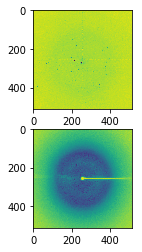

[[ 4.4693494 -1.4379312]]
0.04457788


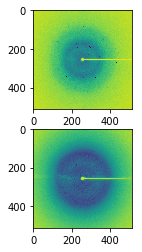

[[ 4.4693494 -1.4379312]]
0.044644427


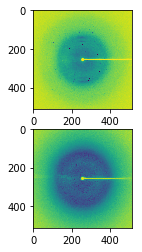

[[ 4.4693494 -1.4379312]]
0.044950273


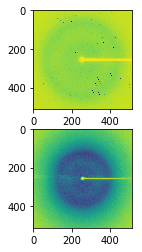

[[ 4.4693494 -1.4379312]]
0.025712732


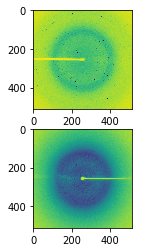

[[ 4.4693494 -1.4379312]]
0.023666577


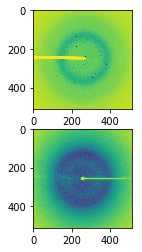

[[ 4.4693494 -1.4379312]]
0.03432503


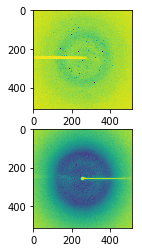

[[ 4.4693494 -1.4379312]]
0.018957507


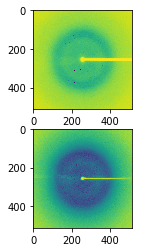

[[ 4.4693494 -1.4379312]]
0.01791992


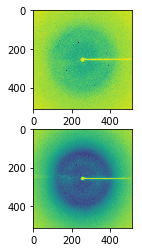

[[ 4.4693494 -1.4379312]]
0.08678408


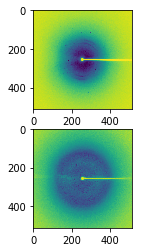

[[ 4.4693494 -1.4379312]]
0.046323758


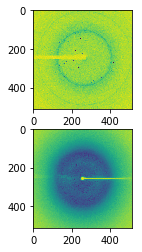

[[ 4.4693494 -1.4379312]]
0.032197773


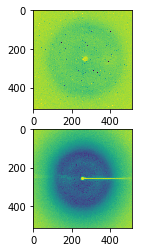

[[ 4.4693494 -1.4379312]]
0.07379957


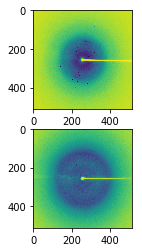

[[ 4.4693494 -1.4379312]]
0.021242592


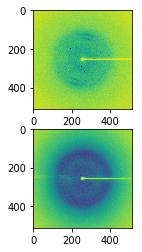

[[ 4.4693494 -1.4379312]]
0.043726966


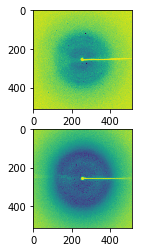

[[ 4.4693494 -1.4379312]]
0.019467663


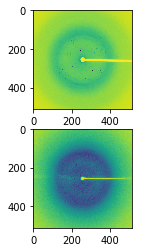

In [147]:
tf.reset_default_graph()

x = tf.placeholder(test_images.dtype, test_images.shape[-2:])
loss, output, latent = autoencoder(x)

with tf.Session() as sess:
    tf.train.Saver().restore(sess, "./TEMP")
    print("Model restored.")
    for im in test_images:
        latent_res, output_res, loss_res = sess.run([latent, output, loss], feed_dict={x : im}) 
        print(latent_res)
        print(loss_res)
        _, ax = plt.subplots(2,1)
        ax[0].imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE))
        ax[1].imshow(output_res.reshape(IMAGE_SIZE, IMAGE_SIZE))
        plt.show()